In [1]:
import cv2
import torch
from matplotlib import pyplot as plt
from d2go.runner import GeneralizedRCNNRunner
from d2go.model_zoo import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from d2go.utils.demo_predictor import DemoPredictor
from detectron2.structures import Boxes, Instances

In [2]:
# Load the configuration like in the training script
runner = GeneralizedRCNNRunner()
cfg = runner.get_default_cfg()
cfg.merge_from_file(model_zoo.get_config_file("faster_rcnn_fbnetv3a_C4.yaml"))
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

INFO:d2go.runner.default_runner:Initializing control pg


In [3]:
# Load the trained model weights
model_path = "/home/yali/coco-annotator/trained-models/model_weights_958-203_rcnn_fbnetv3a_C4.pth"
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

MetadataCatalog.get("fire_train").set(thing_classes=["fire"])
MetadataCatalog.get("fire_val").set(thing_classes=["fire"])
model = runner.build_model(cfg)
model.load_state_dict(torch.load(model_path, map_location=cfg.MODEL.DEVICE))
model.eval()  # Set the model to evaluation mode

INFO:d2go.modeling.backbone.fbnet_v2:Using un-unified arch_def for ARCH "FBNetV3_A" (without scaling):
trunk
- [('conv_k3', 16, 2, 1), ('ir_k3', 16, 1, 2, {'expansion': 1}, {'less_se_channels': False})]
- [('ir_k5', 24, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5', 24, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5_se', 32, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3_se', 32, 1, 3, {'expansion': 3}, {'less_se_channels': False})]
- [('ir_k5', 64, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3', 64, 1, 3, {'expansion': 3}, {'less_se_channels': False}), ('ir_k5_se', 112, 1, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k5_se', 112, 1, 5, {'expansion': 3}, {'less_se_channels': False})]
rpn
- [('ir_k5_se', 112, 1, 5, {'expansion': 3}, {'less_se_channels': False})]
bbox
- [('ir_k5_se', 184, 2, 1, {'expansion': 4}, {'less_se_channels': False}), ('ir_k3_se', 184, 1, 4, {'expansion': 4}, {'less_se_channels': False}),

GeneralizedRCNN(
  (backbone): FBNetV2C4Backbone(
    (body): FBNetV2Backbone(
      (trunk0): Sequential(
        (fbnetv2_0_0): ConvBNRelu(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (bn): NaiveSyncBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (fbnetv2_0_1): IRFBlock(
          (dw): ConvBNRelu(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          )
          (pwl): ConvBNRelu(
            (conv): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): NaiveSyncBatchNorm(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (res_conn): TorchAdd(
            (add_func): FloatFunctional(
              (activation_post_process): Identity()
            )
          )
        )
        (fbnetv2_0_2): IRFBlock(
          (dw): ConvB

In [4]:
# Register the datasets instances
from detectron2.data.datasets import register_coco_instances
register_coco_instances("fire_train", {}, "/home/yali/coco-annotator/forest-fires-t.json", "/home/yali/coco-annotator/datasets/forest-fires/train_images")
register_coco_instances("fire_val", {}, "/home/yali/coco-annotator/forest-fires-v.json", "/home/yali/coco-annotator/datasets/forest-fires/val_images")

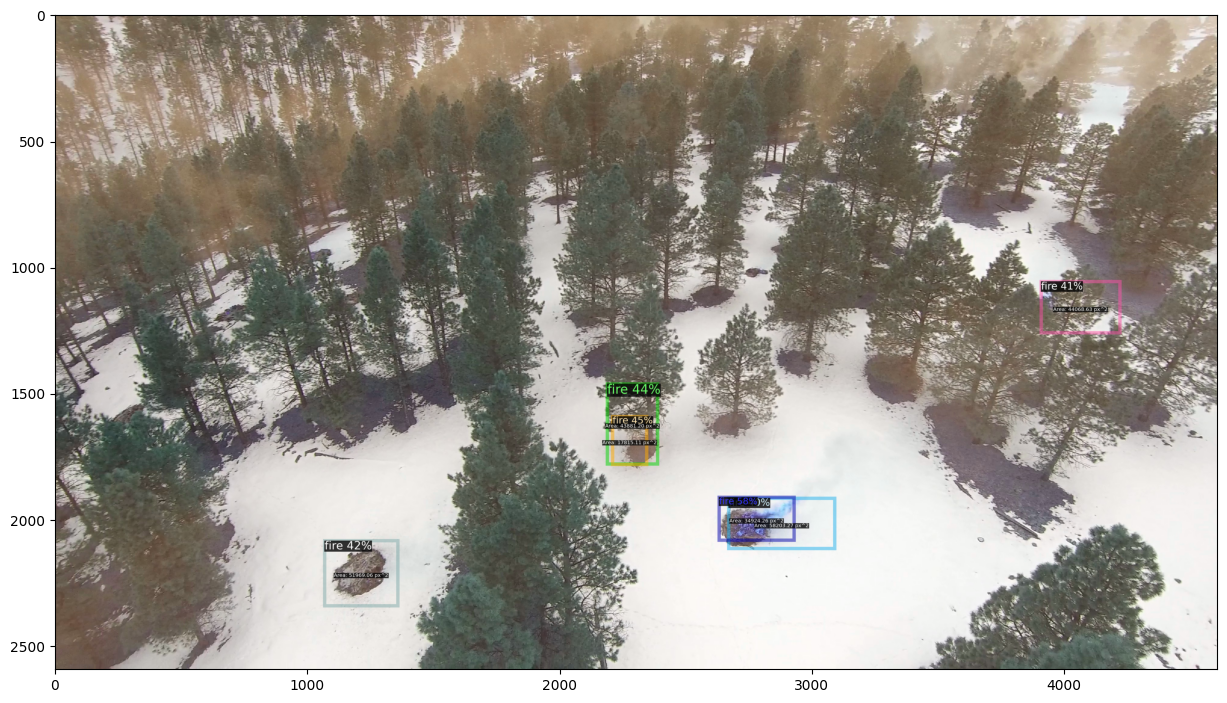

In [19]:
from d2go.utils.demo_predictor import DemoPredictor
from detectron2.structures import Boxes
from detectron2.structures import Instances
from detectron2.utils.visualizer import Visualizer, ColorMode
from matplotlib import pyplot as plt

predictor = DemoPredictor(model)
im = cv2.imread("/home/yali/coco-annotator/datasets/forest-fires/val_images/image_1962.jpg")
outputs = predictor(im)
height, width = im.shape[:2]

# Filtered bounding boxes
boxes_tensor = outputs["instances"].pred_boxes.tensor
scores = outputs["instances"].scores

filtered_indices = []
areas = []  # To store the area of each box
for i, (box, score) in enumerate(zip(boxes_tensor, scores)):
    x1, y1, x2, y2 = box
    box_area = (x2 - x1) * (y2 - y1)
    if box_area / (width * height) <= 0.01 and score >= 0.4:
        filtered_indices.append(i)
        areas.append(box_area)  # Add the area to the list

# Prepare new instances with filtered boxes
new_instances = Instances((height, width))
new_instances.set("pred_boxes", Boxes(boxes_tensor[filtered_indices]))
new_instances.set("pred_classes", outputs["instances"].pred_classes[filtered_indices])
new_instances.set("scores", outputs["instances"].scores[filtered_indices])
outputs["instances"] = new_instances

# Visualization with areas
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get("fire_train"), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Draw area information
for i, box_tensor in enumerate(new_instances.pred_boxes):
    # Calculate the area (already done, just accessing it here)
    area_text = f"Area: {areas[i]:.2f} px^2"

    # Calculate box center
    x1, y1, x2, y2 = box_tensor.cpu().numpy()
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2

    # Draw the area text near the center of the box
    v.draw_text(area_text, (center_x, center_y), font_size=12, color="white")

# Convert the visualizer's drawing to an image
out_image = v.get_output().get_image()

plt.figure(figsize=(15, 10))
plt.imshow(out.get_image()[:, :, ::-1])
#plt.imshow(out_image)
plt.show()


In [12]:
out_image_box = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGB2BGR)
save_path_1 = "/home/yali/coco-annotator/test_image_boxes.jpg"
cv2.imwrite(save_path_1, out_image_box)

True

In [ ]:
plt.figure(figsize=(20, 15))
plt.imshow(out_image)
plt.show()

In [ ]:
out_image_bgr = cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR)
save_path = "/home/yali/coco-annotator/test_image.jpg"
cv2.imwrite(save_path, out_image_bgr)